In [1]:
import tensorflow

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

In [3]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
from imutils import paths

In [5]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [6]:
DIRECTORY = r"C:\Users\User\Downloads\Dataset\test"
CATEGORIES = ["with_mask", "without_mask"]

In [7]:
print("[INFO] loading images...")
data = []
labels = []

[INFO] loading images...


In [8]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)




In [9]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [20]:
data = np.array(data, dtype="float32")
labels = np.array(labels)
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [21]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [22]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

In [23]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [24]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [25]:
for layer in baseModel.layers:
    layer.trainable = False

In [26]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [19]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________________

In [18]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
6/6 [==============================] - 35s 6s/step - loss: 0.8502 - accuracy: 0.6223 - val_loss: 0.5465 - val_accuracy: 0.7857
Epoch 2/20
6/6 [==============================] - 34s 6s/step - loss: 0.6441 - accuracy: 0.6383 - val_loss: 0.3587 - val_accuracy: 0.8929
Epoch 3/20
6/6 [==============================] - 36s 6s/step - loss: 0.4798 - accuracy: 0.7553 - val_loss: 0.2321 - val_accuracy: 0.9464
Epoch 4/20
6/6 [==============================] - 35s 6s/step - loss: 0.3626 - accuracy: 0.8511 - val_loss: 0.1649 - val_accuracy: 0.9643
Epoch 5/20
6/6 [==============================] - 39s 7s/step - loss: 0.2208 - accuracy: 0.9202 - val_loss: 0.1233 - val_accuracy: 0.9821
Epoch 6/20
6/6 [==============================] - 38s 6s/step - loss: 0.1774 - accuracy: 0.9362 - val_loss: 0.0946 - val_accuracy: 1.0000
Epoch 7/20
6/6 [==============================] - 37s 6s/step - loss: 0.1811 - accuracy: 0.9255 - val_loss: 0.0739 - val_accuracy: 1.0000
Epoch 8/20

In [19]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


In [20]:
predIdxs = np.argmax(predIdxs, axis=1)

In [21]:
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00        28
without_mask       1.00      1.00      1.00        28

    accuracy                           1.00        56
   macro avg       1.00      1.00      1.00        56
weighted avg       1.00      1.00      1.00        56



In [22]:
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


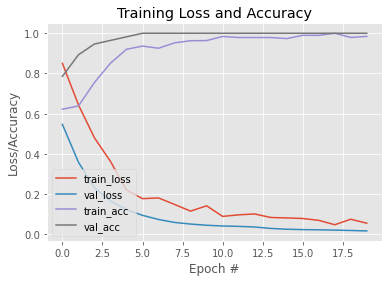

In [23]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [27]:
print(model.evaluate(testX,testY))

7/7 [==============================] - 26s 4s/step - loss: 0.0296 - accuracy: 0.9955
[0.029578786343336105, 0.9954545497894287]


## 